In this experiment we wanted to see if the posters color palette convey any genre information. It might make some sense considering the poster artists likely to use some similar colour tricks to channel genre information to the potential audience.

In [1]:
import random
import os
import itertools
from joblib import Parallel, delayed
from multiprocessing import Pool
import multiprocessing
import cPickle
import numpy as np
import pandas as pd

from skimage import color
from skimage import io

from sklearn import preprocessing
from colorthief import ColorThief
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, make_scorer, classification_report
import matplotlib.colors as clr
import matplotlib.pyplot as plt

from scripts.image import pack_rgb
from scripts.image import unpack_rgb
from scripts.image import palette_dist

%matplotlib inline

In [2]:
prepared_file_name = 'prepared_data/palette.pickle'
tmdb_file_name = 'data/tmdb_info.pickle'

In [3]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [4]:
# extracts 6 color palette
def extract_palette(filename):
    color_thief = ColorThief(filename)
    p = np.array(color_thief.get_palette(color_count = 6))/255.
    return p

def show_palette(p):
    pal = clr.ListedColormap(p)
    a = np.linspace(0, 1, 256).reshape(1,-1)
    a = np.vstack((a,a))
    plt.figure(figsize=(2,2))
    plt.axis("off")
    plt.imshow(a, aspect='auto', cmap = pal)
    plt.text(0, 0, pal, fontsize = 5)

def preprocess(filename):
    color_thief = ColorThief(filename)
    return np.array(color_thief.get_palette(color_count = 6))

Below are two examples of the palette extraction.

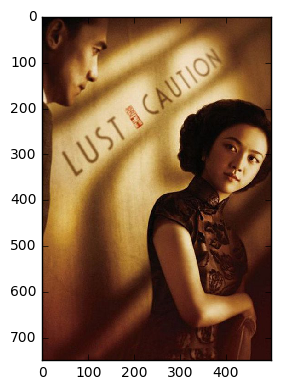

In [5]:
i = io.imread('posters/4588.jpg')
io.imshow(i)

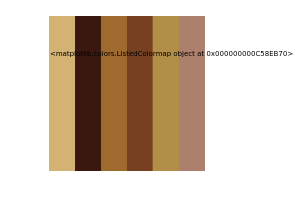

In [6]:
p1 = extract_palette('posters/4588.jpg')
show_palette(p1)

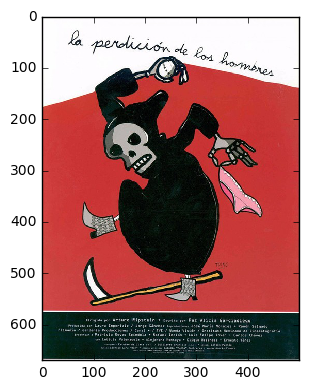

In [7]:
i = io.imread('posters/111649.jpg')
io.imshow(i)

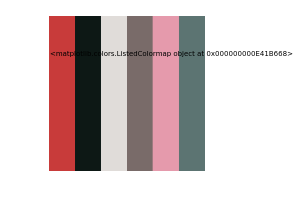

In [8]:
p2 = extract_palette('posters/111649.jpg')
show_palette(p2)

Try to load prepared data

In [9]:
try:
    with open(prepared_file_name, 'rb') as handle:
        model_data = cPickle.load(handle)
except IOError:
    model_data = None

If prepared data (images with palette calculated) is not available - prepare the data.

Subsample

In [10]:
sample_dict = {}
if model_data is None:
    tmdb_dict = load_part(tmdb_file_name)
    for i in range(10000):
        tmdb_id = random.choice(tmdb_dict.keys()) 
        sample_dict[tmdb_id] = tmdb_dict[tmdb_id]
    tmdb_dict = None

In [11]:
print 'Sampled ', len(sample_dict), ' values'

Sampled  0  values


In [12]:
# if we do not have prepared data then do the image pre-processing and save
if model_data is None:
    features = []
    labels = []
    for tmdb_id, tmdb_movie in sample_dict.iteritems():
        filename = 'posters/' + str(tmdb_id) + '.jpg'
        try:
            ip = preprocess(filename)
            features.append(ip)
            labels.append([genre['name'] for genre in tmdb_movie.genres])
        except Exception as e:
            print e
    model_data = (labels, features)
    # save preprocessed images and labels
    with open(prepared_file_name, 'wb') as handle:
        cPickle.dump(model_data, handle, protocol = cPickle.HIGHEST_PROTOCOL)

Build the multil-label dependent variable

In [13]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(model_data[0])
print 'y shape ', y.shape

y shape  (9178L, 20L)


In [14]:
# pack rgb into single integer (sklearn methods do not like 3 dimensional arrays)
X = np.array([map(lambda x: pack_rgb(x), r) for r in model_data[1]])
print 'X shape ', X.shape

X shape  (9178L, 6L)


In [15]:
# kernel computing is computationally expensive
# create smaller work set (half of the observations)
X_throw, X_work, y_throw, y_work = train_test_split(X, y, test_size=0.25, random_state=42)
# use the working set to create test / train data
X_train, X_test, y_train, y_test = train_test_split(X_work, y_work, test_size=0.25, random_state=42)

In [16]:
print 'Train label matrix shape:', y_train.shape
print 'Train predictor matrix shape:', X_train.shape
print 'Test label matrix shape:', y_test.shape
print 'Test predictor matrix shape:', X_test.shape

Train label matrix shape: (1721L, 20L)
Train predictor matrix shape: (1721L, 6L)
Test label matrix shape: (574L, 20L)
Test predictor matrix shape: (574L, 6L)


Genere frequencies in the sample

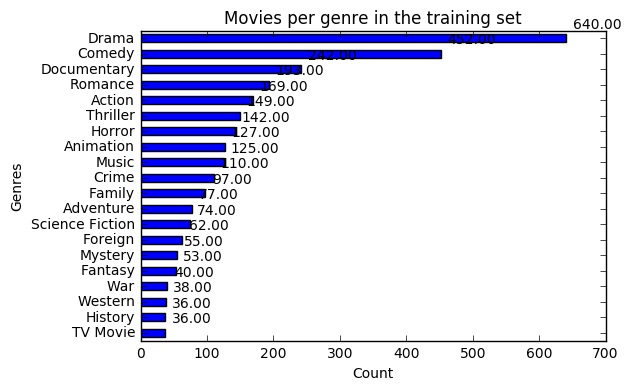

In [17]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

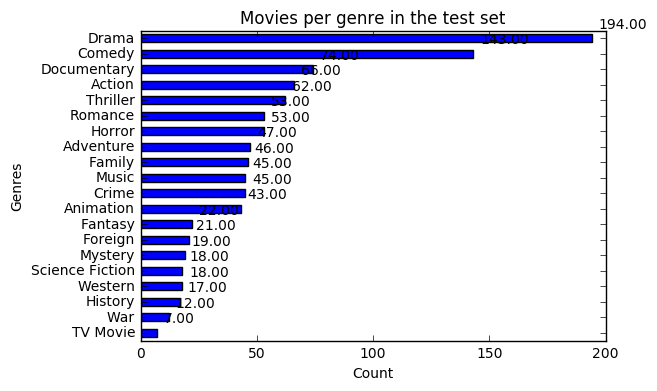

In [ ]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

Distance between two palettes calculated as:  
- pairwise distance between all colors using color difference as given by the CIEDE 2000 standard  
- average first six minimum distances  
The difference is not euclidian and non-linear so we compute the kernel manually.

In [ ]:
# precompute kernel using the custom distance 
kernel_train =  pairwise_distances(X_train, None, metric = palette_dist, n_jobs = -1)

We do not do any CV here just wanted to see if it works in principle.

In [ ]:
model = SVC(kernel='precomputed')
model.fit(ketnel_train, y_train)

In [ ]:
print classification_report(y_train, model_tunning.predict(ketnel_train))

In [ ]:
# precompute kernel using the custom distance 
kernel_test =  pairwise_distances(X_test, None, metric = palette_dist, n_jobs = -1)

In [ ]:
print classification_report(y_test, model_tunning.predict(kernel_test))